In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense,Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam
from scipy.stats import mode
from keras.layers.normalization import BatchNormalization

In [42]:
train_x = pd.read_csv('best_train_x_xgb_k7.csv')
train_y = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\dataset\\train_y_xgboost.csv')
test_x = pd.read_csv('best_test_x_xgb_k7.csv')

In [43]:
from models import Model1xgb,Model1xgb2,Model1xgb3, Model1NNproba,Model1NN2proba,Model1ramdom,Model2KMeans,Model2KNN,Model3logistic,Model3NNproba

In [44]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for i , (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis=0)
    
    return pred_train, preds_test

In [45]:
train_x = train_x.iloc[:,:20]
test_x =  test_x.iloc[:,:20]

In [24]:
train_target = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\train.csv')
test_target = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\test.csv')

#各データセットの作成
train_target_x = train_target.iloc[:,1:17]
train_y = train_target['y']
test_target_x = test_target.iloc[:,1:]

cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
test_target.replace({'job': {'unknown':'blue-collar'}}, inplace=True)


for c in cat_cols:
    #学習データのカテゴリカル変数のカラムごとの変数とtargetをデータフレームとする。
    data_tmp = pd.DataFrame({c:train_target_x[c], 'target': train_y})
    #データフレームのカラムの要素ごとの平均を取る
    target_mean = data_tmp.groupby(c)['target'].mean()
    #訓練データフレームの平均をテストデータに入れる。
    test_target_x.loc[:,c] = test_target_x[c].map(target_mean)
    
    #訓練データを入れるための空の箱を作る
    tmp = np.repeat(np.nan, train_target_x.shape[0])
    
    
    #one of out holdで一つ一つのバリデーションに平均値を入れていく
    kf =  KFold(n_splits=4, shuffle=True, random_state=71)
    for idx_1, idx_2 in kf.split(train_target_x):
        
        target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        
        tmp[idx_2] = train_target_x[c].iloc[idx_2].map(target_mean)
        
    train_target_x[c] = tmp

In [25]:
target_cols_df = train_target_x.loc[:,['job','marital','education','default','housing','loan','contact','month','poutcome']]
target_cols_test_df = test_target_x.loc[:,['job','marital','education','default','housing','loan','contact','month','poutcome']]

In [26]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
for c in cat_cols:
    train_x[c] = target_cols_df[c]
    test_x[c] = target_cols_test_df[c]

In [47]:
model_1c_1 = Model1xgb()
pred_train_1c_1, pred_test_1c_1 = predict_cv(model_1c_1, train_x, train_y, test_x)
print(f'logloss: {log_loss(train_y, pred_train_1c_1, eps=1e-7):.4f}')

[00:04:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.06799	eval-error:0.07055
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[1]	train-error:0.06824	eval-error:0.07041
[2]	train-error:0.06755	eval-error:0.07055
[3]	train-error:0.06814	eval-error:0.07026
[4]	train-error:0.06716	eval-error:0.07011
[5]	train-error:0.06770	eval-error:0.06922
[6]	train-error:0.06731	eval-error:0.06937
[7]	train-error:0.06745	eval-error:0.06937
[8]	train-error:0.06735	eval-error:0.06967
[9]	train-error:0.06731	eval-error:0.06922
[10]	train-error:0.06696	eval-error:0.068

[34]	train-error:0.06470	eval-error:0.07055
[35]	train-error:0.06460	eval-error:0.07041
[36]	train-error:0.06450	eval-error:0.07041
[37]	train-error:0.06431	eval-error:0.07055
[38]	train-error:0.06411	eval-error:0.07055
[39]	train-error:0.06431	eval-error:0.07055
[40]	train-error:0.06411	eval-error:0.07055
[41]	train-error:0.06391	eval-error:0.07041
[42]	train-error:0.06376	eval-error:0.07055
[43]	train-error:0.06347	eval-error:0.07041
[44]	train-error:0.06337	eval-error:0.07070
[45]	train-error:0.06317	eval-error:0.07070
Stopping. Best iteration:
[25]	train-error:0.06627	eval-error:0.07011

[00:04:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0

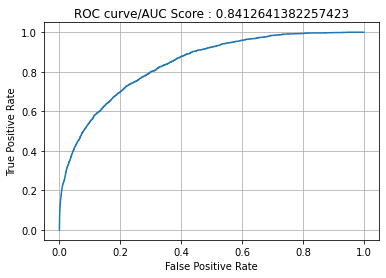

In [48]:
fig = plt.figure()

fpr,tpr,thresholds = roc_curve(train_y,pred_train_1c_1)
auc_score = roc_auc_score(train_y,pred_train_1c_1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve/AUC Score : {auc_score}')

plt.grid(True)

In [49]:
test = pd.read_csv('C:\\Users\\odoru\\SIGNATE_time_deposit_account\\test.csv')
id = test['id']
pred = pd.DataFrame(pred_test_1c_1)
submit = pd.concat([id,pred], axis=1)
submit.columns = ['id', 'y']
submit

,id,y
0,0,0.768482
1,1,0.083425
2,2,0.041881
3,3,0.013485
4,4,0.088655
...,...,...
18045,18045,0.016193
18046,18046,0.019153
18047,18047,0.100561
18048,18048,0.015582


In [50]:
submit.to_csv('xgboost_target3.csv',index=False,header=False)